In [77]:
!wget https://public-esa.ose.gov.pl/api/v1/smog
!mv smog smog.json

--2025-05-23 21:58:10--  https://public-esa.ose.gov.pl/api/v1/smog
Resolving public-esa.ose.gov.pl (public-esa.ose.gov.pl)... 193.59.79.51
Connecting to public-esa.ose.gov.pl (public-esa.ose.gov.pl)|193.59.79.51|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [application/json]
Saving to: ‘smog’

smog                    [  <=>               ] 645.95K  2.98MB/s    in 0.2s    

2025-05-23 21:58:11 (2.98 MB/s) - ‘smog’ saved [661452]



In [78]:
import pandas as pd
import numpy as np
import json
import geopandas as gpd
import osmnx as ox
import contextily as cx
import shapely as sh

In [79]:
def return_ap_by_state(school_data, state_name, country_name, pm_type):
    try:
        # Get the voivodeship (state) geometry
        voivodeship = ox.geocode_to_gdf(state_name + ', ' + country_name).to_crs(crs=2180)['geometry']
        
        # remove schools outside the voivodeship
        data = school_data.to_crs(crs=2180)
        data['inside'] = data.geometry.apply(lambda x: x.within(voivodeship))
        data = data.drop(data[data['inside'] == False].index)
        
        # Simple plot of pm_type measurement
        ax = data.plot(column=pm_type, cmap='coolwarm', legend=True, figsize=(10, 10), alpha=0.5)
        cx.add_basemap(ax, crs=data.crs.to_string())
        ax.set_title(f"AVG {pm_type} of schools with in {state_name}, {country_name}")
        
    except Exception as e:
        print(f"Incorrectly specified region: {state_name}, {country_name}")
        

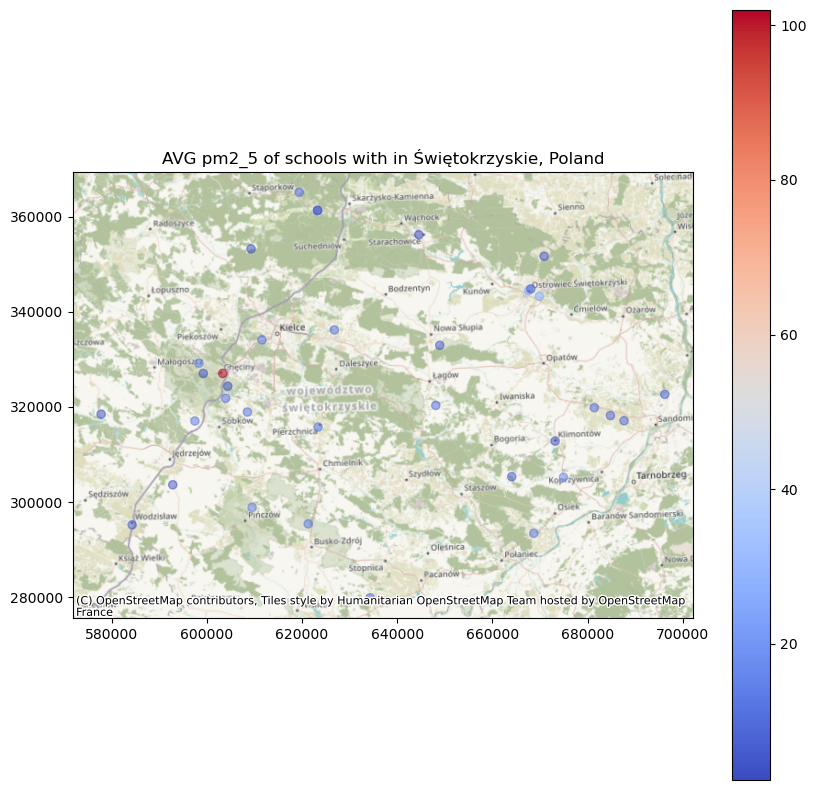

In [81]:
with open('smog.json') as f:
    data = json.load(f)
    
# load json data into a pandas dataframe
df = pd.json_normalize(data['smog_data'])

# basic renaming of columns
df.columns = df.columns.str.removeprefix('school.')
df.columns = df.columns.str.removeprefix('data.')
df.rename(columns = {'pm10_avg': 'pm10', 'pm25_avg': 'pm2_5'}, inplace=True)

# convert latidude and longitude to POINT geometry
df['geometry'] = df[['longitude', 'latitude']].apply(lambda x: f'POINT({x.longitude} {x.latitude})', axis=1)
df = df.drop(columns=['longitude', 'latitude'])

# create GeoPandas DataFrame
df_geo = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['geometry'], crs = 4326))
df_geo.drop(columns=['timestamp'], inplace=True)

# enlarge the geometry to make it easier to see
df_geo['geometry'].apply(lambda x: x.buffer(10, cap_style=1))

# show the measurements of PM2.5 in the Mazowieckie region (from schools that measure it)
return_ap_by_state(df_geo, 'Świętokrzyskie', 'Poland', 'pm2_5')





